## Baseball elimination 

In [20]:
import pandas as pd
import networkx as nx
import csv
import itertools
import ffmaxflow as ff
#import ffmaxc as ffc
import matplotlib.pyplot as plt
from timeit import timeit

El béisbol en los EE.UU. Consta de dos ligas diferentes, cada una de las cuales se divide en tres divisiones de aproximadamente 5 equipos. Durante la temporada regular, cada equipo juega 162 partidos en total, la mayoría de los cuales son contra equipos de su división (76 contra la misma división, 66 contra la misma liga, 20 contra una liga diferente). El objetivo de esto es intentar clasificarse para los playoffs, lo que se puede hacer terminando primero en la división.

Todo esto se suma al deseo de poder determinar si es posible ver si un equipo en particular aún puede potencialmente ganar la división y llegar a los playoffs dada la clasificación actual de la liga. Resolver este problema significa que tenemos que mirar tablas que podrían parecerse a la siguiente:

**Datos**

In [21]:
d = {'Teams': ['LA', 'TX', 'OAK', 'HO'], 'Wins': [82, 80, 78, 77], 
     'Losses': [71, 79, 78, 81],
     'Games_left': [9, 3, 6, 4],
     'LA': [0,1,6,2],
     'TX': [1,0,0,2],
     'OAK': [6,0,0,0],
     'HO': [2,2,0,0]
     }

df = pd.DataFrame(data=d)

df

,Teams,Wins,Losses,Games_left,LA,TX,OAK,HO
0,LA,82,71,9,0,1,6,2
1,TX,80,79,3,1,0,0,2
2,OAK,78,78,6,6,0,0,0
3,HO,77,81,4,2,2,0,0


En este ejemplo se ve claramente que Houston ya está eliminado, la cantidad máxima de victorias que pueden obtener es $77 + 4 = 81$ que es menos de las $82$ victorias que ya tiene LA. Sin embargo, los casos de los tres equipos restantes están todos entrelazados. 
Tomemos a Texas, por ejemplo, si ganan tres juegos pueden llegar a $83$ victorias y superar a Los Ángeles. Sin embargo, para ganar que Texas gane la liga, Los Ángeles debería perder 8 de sus 9 juegos restantes. 
Entonces se tiene el siguiente escenario para LA:
* 1 derrota contra Texas
* 2 derrotas contra Houston
* Y todavía tendría 5 derrotas necesarias de 6 juegos contra Oakland. 

Sin embargo, si esto sucede, Oakland alcanzará 83 victorias y sería el equipo ganador. Claramente, no es suficiente mirar las victorias de un equipo y los juegos que quedan por jugar. Necesitamos considerar contra quién se juegan esos juegos.


Supongamos que el equipo $i$ ya ganó $w_i$ de $r_i$ juegos en total y que $r_{ij}$  es el número de juegos entre los equipos $i$ y $j$ que aún no se han jugado. 
También estableceremos $w_ {max} = w_i + r_i$, de modo que $w_{max}$ es el número máximo de victorias que el equipo puede obtener.

Usando esta notación no podemos eliminar al equipo $i$ si en algún resultado de los juegos restantes que se jugarán a lo largo de la liga, $w_max$ es al menos tan grande como las posibles victorias de todos los demás equipos.

La idea básica es asumir que Oakland gana todos los juegos restantes $w_3 + r_3$
Intentaremos repartir los juegos restantes para que todos los demás equipos tengan $\le w_3 + r_3$ victorias

Si el flujo máximo es igual a la suma de capacidades de los arcos que salen de $s$ (cortadura mínima) a los nodos compuestos por los matches, entonces Oakland gana. Por otro lado, si el flujo máximo es igual a la suma de las capacidades de los arcos simples hacia $t$ entonces Oakland pierde. 

El primer paso para construir la red es crear nodos para cada una de las combinaciones de juegos restantes llamadas nodos de juego en el siguiente ejemplo. Hay un arco que conecta la fuente a cada nodo del juego por separado. Las capacidades de cada uno de estos arcos son el número de juegos que quedan entre los dos equipos representados por el nodo de juego al que está conectado el arco. Esto se muestra en el gráfico como $r_{24}$, el número de juegos que aún deben jugarse entre los equipos $2$ y $4$.



![](../img/baseball_elimination.png)

También requerimos un conjunto de nodos en la red que representen a los equipos conocidos como nodos de equipo. Estos nodos de equipo son alimentados por arcos de cada nodo de juego que involucra a ese equipo en particular. Las capacidades de estos arcos generalmente se modelan como infinitas, ya que el número de juegos adicionales ganados solo está restringido por el número de juegos que quedan por jugar.

Finalmente, hay un nodo sumidero que completa el gráfico al ser alimentado por arcos de todos los nodos del equipo. Las capacidades de estos arcos son la diferencia entre el número total potencial de juegos ganados por el equipo de Oakland y el número de juegos ganados por el equipo $i$. En otras palabras, esta es la cantidad de juegos que los equipos aún pueden ganar mientras el equipo de Oakland todavía no gana.


La forma de saber si el equipo 3 está eliminado o no es averiguar si todos los juegos pueden fluir por la red. Este es un problema de flujo máximo: si el flujo máximo satura todos los arcos que salen de la fuente, el equipo no se elimina, pero si no hay flujo factible, el equipo 3 se elimina lamentablemente.

**Creamos la red con ffmaxflow**

In [149]:
red = ff.create_flow_network()

**Declaramos nodos**

In [150]:
red.create_vertex('s', True, False) #Nodo origen
red.create_vertex('t', False, True) #Nodo destino

#Nodos equipos (partidos)
red.create_vertex('LA', False, False)
red.create_vertex('TX', False, False)
red.create_vertex('OAK', False, False)
red.create_vertex('HO', False, False)

#Nodos combinados (partidos)
red.create_vertex('LA-TX', False, False)
red.create_vertex('LA-OAK', False, False)
red.create_vertex('LA-HO', False, False)
red.create_vertex('TX-OAK', False, False)
red.create_vertex('TX-HO', False, False)
red.create_vertex('OAK-HO', False, False)


**Declaramos arcos**

In [153]:
# Arcos que salen de s a nodos combinados 
red.create_edge('s','LA-TX', 1)
red.create_edge('s','LA-OAK', 6)
red.create_edge('s', 'LA-HO', 2)

red.create_edge('s','TX-HO', 2)

# Arcos nodos equipos a t
red.create_edge('LA', 't', 78 + 6 - 83)
red.create_edge('HO', 't', 78 + 6 - 77)
red.create_edge('TX', 't', 78 + 6 - 80)
red.create_edge('OAK', 't', 78 + 6 - 78 )


# Arcos internos

red.create_edge('LA-TX', 'LA', float('inf'))
red.create_edge('LA-TX', 'TX' , float('inf'))

red.create_edge('LA-OAK', 'LA', float('inf'))
red.create_edge('LA-OAK', 'OAK', float('inf'))

red.create_edge('LA-HO', 'LA', float('inf'))
red.create_edge('LA-HO', 'HO', float('inf'))

red.create_edge('TX-HO', 'TX', float('inf'))
red.create_edge('TX-HO', 'HO', float('inf'))


In [156]:
red.MaxFlow()

11

**ffmaxflowc**

In [26]:
red = ffc.create_flow_network()
red.create_vertex('s', True, False) #Nodo origen
red.create_vertex('t', False, True) #Nodo destino

#Nodos equipos (partidos)
red.create_vertex('LA', False, False)
red.create_vertex('TX', False, False)
red.create_vertex('OAK', False, False)
red.create_vertex('HO', False, False)


#Nodos combinados (partidos)
red.create_vertex('LA-TX', False, False)
red.create_vertex('LA-OAK', False, False)
red.create_vertex('LA-HO', False, False)
red.create_vertex('TX-OAK', False, False)
red.create_vertex('TX-HO', False, False)
red.create_vertex('OAK-HO', False, False)


# Arcos que salen de s a nodos combinados 
red.create_edge('s','LA-TX', 1)
red.create_edge('s','LA-OAK', 6)
red.create_edge('s', 'LA-HO', 2)

red.create_edge('s','TX-HO', 2)

# Arcos nodos equipos a t
red.create_edge('LA', 't', 78 + 6 - 83)
red.create_edge('HO', 't', 78 + 6 - 77)
red.create_edge('TX', 't', 78 + 6 - 80)
red.create_edge('OAK', 't', 78 + 6 - 78 )

# Arcos internos

red.create_edge('LA-TX', 'LA', float('inf'))
red.create_edge('LA-TX', 'TX' , float('inf'))

red.create_edge('LA-OAK', 'LA', float('inf'))
red.create_edge('LA-OAK', 'OAK', float('inf'))

red.create_edge('LA-HO', 'LA', float('inf'))
red.create_edge('LA-HO', 'HO', float('inf'))

red.create_edge('TX-HO', 'TX', float('inf'))
red.create_edge('TX-HO', 'HO', float('inf'))

red.MaxFlow()

11.0

Como la cortadura mínima se encuentra después del nodo origen concluímos con que Oakland ganó la temporada

**networkx**

In [209]:
G = nx.DiGraph()

# Arcos que salen de s a nodos combinados 
G.add_edge('s','LA-TX', capacity = 1)
G.add_edge('s','LA-OAK', capacity = 6)
G.add_edge('s', 'LA-HO',capacity = 2)

G.add_edge('s','TX-HO', capacity =2)

# Arcos nodos equipos a t
G.add_edge('LA', 't', capacity =78 + 6 - 83)
G.add_edge('HO', 't', capacity  =78 + 6 - 77)
G.add_edge('TX', 't', capacity =78 + 6 - 80)
G.add_edge('OAK', 't', capacity =78 + 6 - 78 )

# Arcos internos

G.add_edge('LA-TX', 'LA', capacity =float('inf'))
G.add_edge('LA-TX', 'TX' , capacity =float('inf'))

G.add_edge('LA-OAK', 'LA', capacity =float('inf'))
G.add_edge('LA-OAK', 'OAK', capacity =float('inf'))

G.add_edge('LA-HO', 'LA', capacity =float('inf'))
G.add_edge('LA-HO', 'HO', capacity =float('inf'))

G.add_edge('TX-HO', 'TX', capacity =float('inf'))
G.add_edge('TX-HO', 'HO', capacity =float('inf'))

flow_value, flow_dict = nx.maximum_flow(G, 's', 't')

flow_value

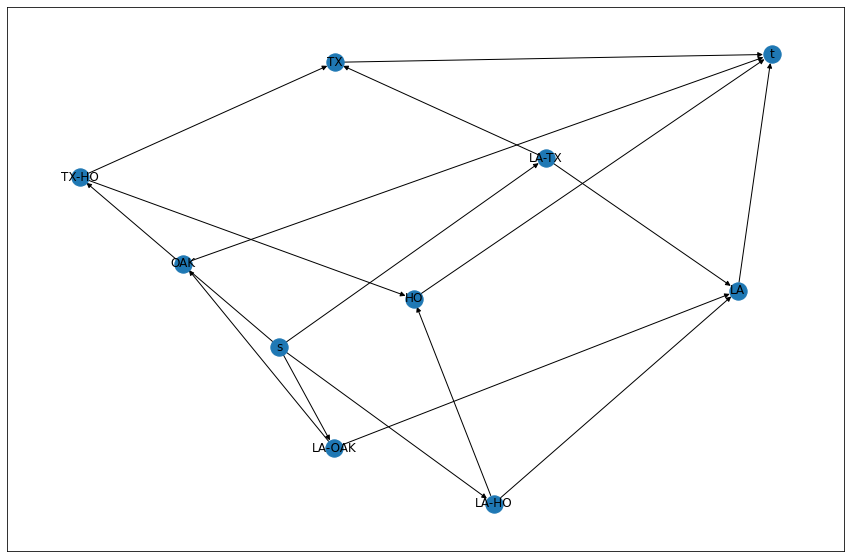

In [214]:
plt.figure(figsize = (15,10))
nx.draw_networkx(G)

**Tiempos**

ffmaxflow

In [219]:
setup_code= """
import pandas as pd
import ffmaxflow as ff

d = {'Teams': ['LA', 'TX', 'OAK', 'HO'], 'Wins': [82, 80, 78, 77], 
     'Losses': [71, 79, 78, 81],
     'Games_left': [9, 3, 6, 4],
     'LA': [0,1,6,2],
     'TX': [1,0,0,2],
     'OAK': [6,0,0,0],
     'HO': [2,2,0,0]
     }

df = pd.DataFrame(data=d)

df

"""
statement = """
red = ff.create_flow_network()

red.create_vertex('s', True, False) #Nodo origen
red.create_vertex('t', False, True) #Nodo destino

#Nodos equipos (partidos)
red.create_vertex('LA', False, False)
red.create_vertex('TX', False, False)
red.create_vertex('OAK', False, False)
red.create_vertex('HO', False, False)

#Nodos combinados (partidos)
red.create_vertex('LA-TX', False, False)
red.create_vertex('LA-OAK', False, False)
red.create_vertex('LA-HO', False, False)
red.create_vertex('TX-OAK', False, False)
red.create_vertex('TX-HO', False, False)
red.create_vertex('OAK-HO', False, False)

# Arcos que salen de s a nodos combinados 
red.create_edge('s','LA-TX', 1)
red.create_edge('s','LA-OAK', 6)
red.create_edge('s', 'LA-HO', 2)

red.create_edge('s','TX-HO', 2)

# Arcos nodos equipos a t
red.create_edge('LA', 't', 78 + 6 - 83)
red.create_edge('HO', 't', 78 + 6 - 77)
red.create_edge('TX', 't', 78 + 6 - 80)
red.create_edge('OAK', 't', 78 + 6 - 78 )


# Arcos internos

red.create_edge('LA-TX', 'LA', float('inf'))
red.create_edge('LA-TX', 'TX' , float('inf'))

red.create_edge('LA-OAK', 'LA', float('inf'))
red.create_edge('LA-OAK', 'OAK', float('inf'))

red.create_edge('LA-HO', 'LA', float('inf'))
red.create_edge('LA-HO', 'HO', float('inf'))

red.create_edge('TX-HO', 'TX', float('inf'))
red.create_edge('TX-HO', 'HO', float('inf'))

red.MaxFlow()

"""

print (timeit(setup = setup_code, stmt = statement, number = 10))

0.002524647999962326


In [220]:
print("Tiempo promedio de una ejecución: {} segundos".format(0.002524647999962326/10))

Tiempo promedio de una ejecución: 0.0002524647999962326 segundos


ffmaxc

In [221]:
setup_code= """
import pandas as pd
import ffmaxc as ffc

d = {'Teams': ['LA', 'TX', 'OAK', 'HO'], 'Wins': [82, 80, 78, 77], 
     'Losses': [71, 79, 78, 81],
     'Games_left': [9, 3, 6, 4],
     'LA': [0,1,6,2],
     'TX': [1,0,0,2],
     'OAK': [6,0,0,0],
     'HO': [2,2,0,0]
     }

df = pd.DataFrame(data=d)

df

"""
statement = """
red = ffc.create_flow_network()

red.create_vertex('s', True, False) #Nodo origen
red.create_vertex('t', False, True) #Nodo destino

#Nodos equipos (partidos)
red.create_vertex('LA', False, False)
red.create_vertex('TX', False, False)
red.create_vertex('OAK', False, False)
red.create_vertex('HO', False, False)

#Nodos combinados (partidos)
red.create_vertex('LA-TX', False, False)
red.create_vertex('LA-OAK', False, False)
red.create_vertex('LA-HO', False, False)
red.create_vertex('TX-OAK', False, False)
red.create_vertex('TX-HO', False, False)
red.create_vertex('OAK-HO', False, False)

# Arcos que salen de s a nodos combinados 
red.create_edge('s','LA-TX', 1)
red.create_edge('s','LA-OAK', 6)
red.create_edge('s', 'LA-HO', 2)

red.create_edge('s','TX-HO', 2)

# Arcos nodos equipos a t
red.create_edge('LA', 't', 78 + 6 - 83)
red.create_edge('HO', 't', 78 + 6 - 77)
red.create_edge('TX', 't', 78 + 6 - 80)
red.create_edge('OAK', 't', 78 + 6 - 78 )


# Arcos internos

red.create_edge('LA-TX', 'LA', float('inf'))
red.create_edge('LA-TX', 'TX' , float('inf'))

red.create_edge('LA-OAK', 'LA', float('inf'))
red.create_edge('LA-OAK', 'OAK', float('inf'))

red.create_edge('LA-HO', 'LA', float('inf'))
red.create_edge('LA-HO', 'HO', float('inf'))

red.create_edge('TX-HO', 'TX', float('inf'))
red.create_edge('TX-HO', 'HO', float('inf'))

red.MaxFlow()

"""

print (timeit(setup = setup_code, stmt = statement, number = 10))

0.0015956180013745325


In [222]:
print("Tiempo promedio de una ejecución: {} segundos".format(0.0015956180013745325/10))

Tiempo promedio de una ejecución: 0.00015956180013745324 segundos


networkx

In [223]:
setup_code= """
import pandas as pd
import networkx as nx

d = {'Teams': ['LA', 'TX', 'OAK', 'HO'], 'Wins': [82, 80, 78, 77], 
     'Losses': [71, 79, 78, 81],
     'Games_left': [9, 3, 6, 4],
     'LA': [0,1,6,2],
     'TX': [1,0,0,2],
     'OAK': [6,0,0,0],
     'HO': [2,2,0,0]
     }

df = pd.DataFrame(data=d)

df

"""
statement = """
G = nx.DiGraph()

# Arcos que salen de s a nodos combinados 
G.add_edge('s','LA-TX', capacity = 1)
G.add_edge('s','LA-OAK', capacity = 6)
G.add_edge('s', 'LA-HO',capacity = 2)

G.add_edge('s','TX-HO', capacity =2)

# Arcos nodos equipos a t
G.add_edge('LA', 't', capacity =78 + 6 - 83)
G.add_edge('HO', 't', capacity  =78 + 6 - 77)
G.add_edge('TX', 't', capacity =78 + 6 - 80)
G.add_edge('OAK', 't', capacity =78 + 6 - 78 )

# Arcos internos

G.add_edge('LA-TX', 'LA', capacity =float('inf'))
G.add_edge('LA-TX', 'TX' , capacity =float('inf'))

G.add_edge('LA-OAK', 'LA', capacity =float('inf'))
G.add_edge('LA-OAK', 'OAK', capacity =float('inf'))

G.add_edge('LA-HO', 'LA', capacity =float('inf'))
G.add_edge('LA-HO', 'HO', capacity =float('inf'))

G.add_edge('TX-HO', 'TX', capacity =float('inf'))
G.add_edge('TX-HO', 'HO', capacity =float('inf'))

flow_value, flow_dict = nx.maximum_flow(G, 's', 't')

flow_value
"""

print (timeit(setup = setup_code, stmt = statement, number = 10))

0.006794693999836454


In [225]:
print("Tiempo promedio de una ejecución: {} segundos".format(0.006794693999836454/10))

Tiempo promedio de una ejecución: 0.0006794693999836454 segundos
